# Training Loop
在本章中，我们将：
- 构建一个函数来执行训练步骤。
- 使用数据加载器生成小批量。
- 构建一个函数来执行小批量梯度下降。
- 集成 TensorBoard 以监控模型训练。
- 将我们的模型保存/检查点到磁盘。
- 从磁盘加载我们的模型以恢复训练或部署。

本章需要导入的库：

In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## 引入高阶函数
高阶函数是指接受函数作为参数或返回函数的函数。在本章中，我们将使用高阶函数来构建训练循环。
### 使用不同的优化器、损失和模型 
“如果我们使用不同的优化器、损失甚至模型，训练循环中的代码会改变吗？”——————答案是不。

模型训练涉及循环四个梯度下降步骤（或一个训练步骤），无论我们使用哪种模型、损失或优化器，它们总是相同的（这可能有例外，但它适用对于本课程的范围）。以模型训练的代码为例：

```python
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()

    # Step 1 - computes model's predicted output - forward pass
    # No more manual prediction!
    yhat = model(x_train_tensor)
    
    # Step 2 - computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()

print(loss)
```
我想我们可以说所有这些代码行（模型训练的 5-21 行）都执行了一个训练步骤。对于模型、损失和优化器的给定组合，它将特征和相应的标签作为参数。但是我们可以做得更好，我们可以将这些步骤封装在一个函数中（也就是说我们要写一个返回另一个函数的函数），以便我们可以在不同的模型、损失和优化器之间进行切换。这就是我们将要做的事情。

## 高阶函数 
虽然这更像是一个编码主题，但我认为有必要很好地掌握高阶函数的工作原理，以充分利用 Python 的功能并充分利用我们的代码。在这里，我们将用一个例子来说明高阶函数，这样你就可以获得它的应用知识，但我们不会深入探讨这个主题，因为它超出了本课程的范围。假设我们想要构建一系列函数，每个函数执行给定幂的幂运算。代码如下所示：
    
```python
    def square(x):
    return x ** 2

    def cube(x):
    return x ** 3
 
    def fourth_power(x):
    return x ** 4
```
每个函数都有一个参数 x ，这是我们想要取幂的数字。每个函数执行相同的运算（求幂），但每个函数都有不同的指数。解决这个问题的一种方法是使指数成为显式参数，有一个更高级的结构，就像下面的代码一样：
```python
def generic_exponentiation(x, exponent):
    return x ** exponent

print(generic_exponentiation(2, 5))
```
这很好，而且效果很好。但它还要求您在每次调用该函数时都指定指数。

我们需要构建另一个高阶函数来为我们构建那些函数（正方形、立方体等）。高阶函数只是一个函数构建器。但是我们该怎么做呢？首先，让我们构建我们尝试生成的函数的“骨架”。它们都采用单个参数 x ，并且它们都执行取幂，每个都使用不同的指数。  
```python
def skeleton_exponentiation(x):
    return x ** exponent

skeleton_exponentiation(2)
```
但是，如上面的代码所示，如​​果您尝试使用任何 x 调用此函数（例如 skeleton_exponentiation(2) ），您将得到 NameError: name 'exponent' is not defined 。这是预料之中的，您的“骨架”函数不知道变量 exponent 是什么！这就是高阶函数要完成的。

在这里，我们用高阶函数“包装”我们的骨架函数，这将构建所需的函数。让我们把它称为 exponentiation_builder ，而不是缺乏想象力。如果有的话，它的论点是什么？好吧，我们正试图告诉我们的骨架函数它的指数应该是什么，所以让我们从它开始。
```python
def exponentiation_builder(exponent):
    def skeleton_exponentiation(x):
    	return x ** exponent
 		
	return skeleton_exponentiation
```
现在，我希望您看一下（外部） return 语句。它没有返回值；它正在返回骨架函数。毕竟这是一个函数生成器；它应该构建（并返回）函数。
如果我们用给定的指数 2 调用这个高阶函数会发生什么？

In [15]:
def exponentiation_builder(exponent):
	def skeleton_exponentiation(x):
		return x ** exponent
	
	return skeleton_exponentiation

returned_function = exponentiation_builder(2)
print(returned_function)

<function exponentiation_builder.<locals>.skeleton_exponentiation at 0x000001CC622B8430>


正如预期的那样，结果是一个函数！这个函数有什么作用？它应该正视它的论点。让我们检查一下：

In [16]:
def exponentiation_builder(exponent):
	def skeleton_exponentiation(x):
		return x ** exponent
	
	return skeleton_exponentiation

returned_function = exponentiation_builder(2)
print(returned_function(5))

25


我们有一个函数生成器！我们可以使用它来创建任意数量的求幂函数：

In [17]:
square = exponentiation_builder(2)
cube = exponentiation_builder(3)
fourth_power = exponentiation_builder(4)

# and so on and so forth...
print(square(4), cube(4), fourth_power(4))

16 64 256


说了这么多，那么他又“**如何应用于训练循环？**”

我们将做一些类似于我们的训练循环的事情，相当于高阶函数的 exponent 参数是模型、损失和优化器的组合。每次我们针对一组不同的特征和标签（相当于骨架函数中的 x 参数）执行训练步骤时，我们将使用相同的模型、损失和优化器。

In [18]:
def calculate_result(num):
    def equation(x):

        def equation2(y):
            return (x + num) / (y - num)

        return equation2

    return equation

res = calculate_result(2)
res2 = res(4)
print(res2(5))

2.0


## 重新思考训练循环
### 训练步骤 
如前所述，为我们构建训练步函数的高阶函数采用了我们训练循环的关键元素：模型、损失和优化器。实际要返回的训练步函数将有两个参数，即特征和标签，并将返回相应的损失值。
### 为训练步骤创建高阶函数
除了返回损失值外，下面的 perform_train_step() 内部函数与模型训练V0中循环内的代码相同。代码应如下所示：

In [19]:
#为迭代训练创建高阶函数
def make_train_step(model, loss_fn, optimizer):
    
    def perform_train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        
        # Step 1 - computes model's predictions - forward pass
        yhat = model(x)
        # Step 2 - computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - computes gradients for "b" and "w" parameters
        loss.backward()
        # Step 4 - updates parameters using gradients and
        # the learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the 
    # train loop
    return perform_train_step

### 更新模型配置代码 
然后，我们需要更新我们的模型配置代码来调用这个高阶函数来构建一个 train_step 函数。但是我们需要先运行数据准备脚本。

%run -i data_preparation/v0.py

配置模型的代码如下所示：

In [20]:
%%writefile model_configuration/v1.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function 
# and optimizer
train_step = make_train_step(model, loss_fn, optimizer) # 1)

Overwriting model_configuration/v1.py


我们现在需要运行这个模型配置 V1 脚本:

In [21]:
%run -i model_configuration/v1.py

现在，让我们检查一下我们的 train_step 函数！

In [22]:
# displaying the train_step function
print(train_step)

<function make_train_step.<locals>.perform_train_step at 0x000001CC6230B160>


## 更新模型训练代码
现在我们需要更新我们的模型训练，以调用我们新创建的函数来替换循环内的代码。
我们的代码应该如下所示：

In [23]:
%%writefile model_training/v1.py

# Defines number of epochs
n_epochs = 1000

losses = []                                            # 2)

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)  # 1)
    losses.append(loss)                                # 2)

Overwriting model_training/v1.py


下面参考上面代码中发生的过程的步骤：

- 执行一个训练步骤（第 11 行）

- 跟踪训练损失（第 6 行和第 12 行）

注意到训练循环现在有多小了吗？现在 make_train_step 辅助函数中有很多样板代码！

我们如何检查我们的更改是否没有引入任何错误？我们可以检查模型的 state_dict() ：


In [24]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')), ('0.bias', tensor([0.8300], device='cuda:0'))])


## 构建数据集
### Dataset类
在 PyTorch 中，数据集由继承自 Dataset 类的常规 Python 类表示。你可以把它想象成一个元组列表，每个元组对应一个点（特征，标签）。

它需要实现的最基本的方法是：

- __init__(self) ：它接受构建元组列表所需的任何参数；它可能是将被加载和处理的 CSV 文件的名称；它可能是两个张量，一个用于特征，另一个用于标签；或其他任何东西，取决于手头的任务。

无需在构造方法 ( __init__ ) 中加载整个数据集。如果您的数据集很大（例如，数万个图像文件），一次加载它不会节省内存。建议在调用 __get_item__ 时按需加载它们。

- __get_item__(self, index) ：它允许对数据集进行索引，以便它可以像列表一样工作 ( dataset[i] )。它应该返回一个与请求的数据点对应的元组（特征，标签）。我们可以返回预加载数据集的相应切片，或者如上所述，按需加载它们（如本例所示）。

- __len__(self) ：它应该简单地返回整个数据集的大小。因此，无论何时对其进行采样，其索引都限于实际大小。

### 构建自定义数据集 
让我们构建一个简单的自定义数据集，它将两个张量作为参数：一个用于特征，一个用于标签。对于任何给定的索引，我们的数据集类将返回每个张量的相应切片。它应该是这样的：


In [25]:
import numpy as np
# Variables initialized
true_b = 1
true_w = 2
N = 100

# Data generation process
np.random.seed(42)#保证每次产生的随机数相同
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))#epsilon是噪声，.1是噪声的标准差 np.random.randn(N, 1)是N行1列的随机数
y = true_b + true_w * x + epsilon
idx = np.arange(N)
np.random.shuffle(idx)

# 使用80个随机索引作为训练集
train_idx = idx[:int(N*.8)]
#使用剩下的20个随机索引作为验证集
val_idx = idx[int(N*.8):]

# 生成训练集和验证集
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


你有没有注意到我们用 Numpy 数组构建了训练张量，但我们没有将它们发送到设备？所以，它们现在是 CPU 张量。为什么？我们不希望我们的整个训练数据都加载到 GPU 张量中，就像我们到目前为止在示例中所做的那样，因为它会占用我们宝贵的图形卡 RAM 中的空间。
### TensorDataset类
再一次，你可能会想，“为什么要费这么大劲在一个类中包装几个张量呢？”而且，再一次，你确实有一点。如果一个数据集只不过是几个张量，我们可以使用 PyTorch 的 TensorDataset 类，它的作用与我们上面的自定义数据集几乎相同。

现在，成熟的自定义数据集类可能看起来有点牵强，但我们将在后面的章节中重复使用这种结构。现在，让我们享受一下 TensorDataset 类的简单吧！

In [26]:
# using TensorDataset instead of making a custom class
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


## DataLoader 数据加载器
### 简介
到目前为止，我们在每个训练步骤都使用了整个训练数据。一直都是批量梯度下降。这对于我们的小数据集来说很好，但是如果我们想让我们的工作更有效率并且计算成本更低，我们必须使用小批量梯度下降。因此，我们需要小批量，我们需要相应地切片我们的数据集。你想手动做吗？我也不！

因此，我们使用 PyTorch 的 DataLoader 类来完成这项工作。但是，我们必须告诉它使用哪个数据集。在这种情况下，我们将选择上一课的数据集、所需的小批量大小，以及是否要对其进行洗牌。就是这样！

**重要提示：**在绝大多数情况下，您应该为训练集设置 shuffle=True 以提高梯度下降的性能。不过也有一些例外。例如，时间序列问题是一个例外，其中洗牌实际上会导致数据泄漏。因此，请始终问自己：“我有理由不对数据进行洗牌吗？”、“验证集和测试集呢？”没有必要打乱它们，因为我们没有用它们计算梯度。DataLoader 所见所闻远不止于此。例如，也可以将它与采**样器一起使用**来获取补偿不平衡类的小批量。现在处理的太多了，但我们最终会到使用到。
### 选择小批量大小
在我们的示例中，我们只有 80 个训练点，因此我们选择 16 的小批量大小以方便地将训练集分成五个小批量。

要检索小批量，只需运行以下命令即可。它将返回一个包含两个张量的列表，一个用于特征，另一个用于标签：


In [27]:
train_loader = DataLoader(
    dataset=train_data, 
    batch_size=16, 
    shuffle=True,
)
#将会返回2个张量，分别是特征和标签，next()函数返回的是一个元组
print(next(iter(train_loader)))

[tensor([[0.2809],
        [0.3253],
        [0.1560],
        [0.5924],
        [0.0651],
        [0.8872],
        [0.4938],
        [0.0055],
        [0.1409],
        [0.0885],
        [0.1849],
        [0.7290],
        [0.8662],
        [0.3117],
        [0.6842],
        [0.1987]]), tensor([[1.5846],
        [1.8057],
        [1.2901],
        [2.1687],
        [1.1559],
        [2.8708],
        [1.9060],
        [1.0632],
        [1.1211],
        [1.0708],
        [1.5888],
        [2.4927],
        [2.6805],
        [1.7637],
        [2.3492],
        [1.2654]])]


### 我们实施的变化
到目前为止，这如何改变我们的代码？让我们检查一下！首先，我们需要将 Dataset 和 DataLoader 元素添加到代码的数据准备部分。另外，请注意我们还没有将张量发送到设备。它应该是这样的：

In [28]:
%%writefile data_preparation/v1.py

# Our data was in Numpy arrays, but we need to transform them
# into PyTorch's Tensors
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

# Builds Dataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)  # 1)

# Builds DataLoader
train_loader = DataLoader(                                  # 2)
    dataset=train_data, 
    batch_size=16, 
    shuffle=True,
)

Overwriting data_preparation/v1.py


以下是指上述代码中发生的过程的步骤：

构建张量数据集（第 9 行）。
构建一个产生大小为 16 的小批量的数据加载器（第 12-16 行）。
现在需要以下命令来运行数据准备脚本：

In [29]:
%run -i data_preparation/v1.py

接下来，我们需要将小批量梯度下降逻辑合并到代码的模型训练部分。但是我们需要先运行模型配置脚本。

In [30]:
%run -i model_configuration/v1.py

以下代码显示了被纳入模型训练部分的小批量梯度：

In [31]:
%%writefile model_training/v2.py

# Defines number of epochs
n_epochs = 1000

losses = []

# For each epoch...
for epoch in range(n_epochs):
    # inner loop
    mini_batch_losses = []                              # 4)
    for x_batch, y_batch in train_loader:               # 1)
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)                    # 2)
        y_batch = y_batch.to(device)                    # 2)

        # Performs one train step and returns the 
        # corresponding loss for this mini-batch
        mini_batch_loss = train_step(x_batch, y_batch)  # 3)
        mini_batch_losses.append(mini_batch_loss)       # 4)

    # Computes average loss over all mini-batches
    # That's the epoch loss
    loss = np.mean(mini_batch_losses)                   # 5)    
    losses.append(loss)

Overwriting model_training/v2.py


以下是指上述代码中发生的过程的步骤:
- 小批量内循环（第 12 行）。
- 向设备发送一个小批量（第 16-17 行）。
- 执行训练步骤（第 21 行）。
- 跟踪每个小批量中的损失（第 11 和 22 行）。
- 平均 mini-batches 的损失以获得 epoch 的损失（第 26 行）。
好像变了很多。让我们一步一步地仔细看看：
- 我们添加了一个内部循环来处理 DataLoader 生成的小批量（第 12 行）。
- 我们只向设备发送了一个小批量，而不是发送整个训练集（第 16 和 17 行）
- 对于更大的数据集，在 Dataset 的 __get_item__ 方法中按需加载数据（到 CPU 张量中），然后将属于同一小批量的所有数据点一次发送到您的 GPU 设备是充分利用您的方法显卡的内存。此外，如果你有很多 GPU 来训练你的模型，最好让你的数据集“与设备无关”，并在训练期间将批次分配给不同的 GPU。
- 我们对小批量执行了 train_step （第 21 行），并将相应的损失附加到列表中（第 22 行）。在遍历所有小批量之后，即在一个时期结束时，我们计算了该时期的总损失，即所有小批量的平均损失，将结果附加到列表中（第 26 和 27 行）。

写好文件后，我们还需要运行上面刚刚定义的这个模型训练V2脚本：

In [32]:
%run -i model_training/v2.py

还不错，对吧？所以，是时候检查我们的代码是否还能正常工作了：

In [33]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9696]], device='cuda:0')), ('0.bias', tensor([1.0243], device='cuda:0'))])


现在训练时间更长了，因为内循环在每个 epoch 执行了五次。在我们的示例中，由于我们使用的是大小为 16 的小批量并且我们总共有 80 个训练数据点，因此我们执行内部循环 80 / 16 = 5 次。因此，我们总共调用了 train_step 5,000 次！难怪它需要更长的时间！

## 小批量内循环和训练拆分
### 内循环 
从现在开始，无论是在本课程中还是在现实生活中，您都不太可能再次使用（完整的）批量梯度下降法。所以再一次，将一段将要重复使用的代码组织到它自己的函数中是有意义的：小批量内循环！

内部循环取决于三个元素：
- 数据发送到的设备。
- 从中提取小批量数据的数据加载器。
- 阶跃函数，返回相应的损失。

将这些元素作为输入并使用它们执行内部循环，我们最终将得到如下函数：

In [34]:

def mini_batch(device, data_loader, step):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = step(x_batch, y_batch)
        #mini_batch_losses.append(mini_batch_loss.item())的作用是将mini_batch_loss转换为标量
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

在上一课中，我们意识到由于小批量内部循环，我们每个时期执行了五倍多的更新（ train_step 函数）。以前，1,000 个epoch来意味着 1,000 次更新。现在，我们只需要 200 个epoch来执行相同的 1,000 次更新。

我们的训练循环现在看起来如何？变得很瘦了！

In [35]:
%%writefile model_training/v3.py

# Defines number of epochs
n_epochs = 200

losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step) # 1)
    losses.append(loss)

Overwriting model_training/v3.py


在运行新的模型训练代码之前，我们必须先运行数据准备和模型配置的脚本：

In [36]:
%run -i data_preparation/v1.py
%run -i model_configuration/v1.py

在此之后，我们将运行模型训练脚本：

In [37]:
%run -i model_training/v3.py

让我们检查模型的状态：

In [38]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9684]], device='cuda:0')), ('0.bias', tensor([1.0219], device='cuda:0'))])


到目前为止，我们只关注训练数据。我们为它构建了一个数据集和一个数据加载器。我们可以使用在本课程开始时执行的拆分对验证数据执行相同的操作，或者我们可以改用 random_split 。PyTorch 的 random_split() 方法是执行训练-验证拆分的一种简单且熟悉的方法。

到目前为止，我们一直在使用 x_train_tensor 和 y_train_tensor （基于 Numpy 中的原始拆分构建）来构建训练数据集。现在，我们将首先使用 Numpy 的完整数据（ x 和 y ）构建 PyTorch Dataset ，然后才使用 random_split() 拆分数据。

然后，对于每个数据子集，我们正在构建一个对应的 DataLoader ，因此我们的代码如下所示：

In [39]:
%%writefile data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()                          # 1)
y_tensor = torch.as_tensor(y).float()                          # 1)

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8#训练集占比
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
train_data, val_data = random_split(dataset, [n_train, n_val])  # 2) 

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_data, 
    batch_size=16, 
    shuffle=True,
)
val_loader = DataLoader(dataset=val_data, batch_size=16)        # 3)

Overwriting data_preparation/v2.py


以下是指上述代码中发生的过程的步骤：
- 从完整数据集（拆分前）制作张量（第 6-7 行）。
- 在 PyTorch 中执行训练验证拆分（第 17 行）。
- 为验证集创建数据加载器（第 25 行）。

接下来，我们将运行这个脚本：

In [40]:
%run -i data_preparation/v2.py

## 评估
### 如何评价模型 
我们如何评估模型？我们可以计算验证损失，即模型对未见数据的预测有多错误。首先，我们需要使用模型计算预测，然后使用损失函数计算损失，给定我们的预测和真实标签。听起来很熟悉？这些几乎是我们作为辅助函数 #1 构建的训练步骤函数的前两个步骤。

因此，我们可以使用该代码作为起点，摆脱它的第 3 步和第 4 步。而且，最重要的是，我们需要使用模型的 eval() 方法。它所做的唯一一件事就是将模型设置为评估模式（就像它的 train() 对应物所做的那样），因此模型可以在必须执行某些操作（如 eval() ）时相应地调整其行为。

你可能会问“为什么设置eval()？”。这是因为在训练模式下，模型将执行一些操作，例如应用 dropout ，而在评估模式下，它将不会执行这些操作。这是因为在训练模式下，我们希望模型能够学习数据的不同方面，而在评估模式下，我们希望模型能够对未见数据进行预测。因此，我们需要确保在评估模式下，模型不会执行任何训练模式下的操作,所以我们使用 model.eval() 来防止它。

就像 make_train_step （我们的新函数）一样， make_val_step 也是一个高阶函数。它的代码如下所示：

In [41]:
def make_val_step(model, loss_fn):
    # Builds function that performs a step 
    # in the validation loop
    def perform_val_step(x, y):
        # 设置进入评估模式
        model.eval()     # 1)
        
        # Step 1 - Computes our model's predicted output
        # forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, 
        # since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step

然后，我们更新模型配置代码以包括为验证步骤创建相应的函数。

In [42]:
%%writefile model_configuration/v2.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function 
# and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step = make_val_step(model, loss_fn)  # 1)

Overwriting model_configuration/v2.py


我们现在还需要运行 V2 模型配置脚本：

In [43]:
%run -i model_configuration/v2.py

最后，我们需要更改训练循环以包括对我们模型的评估。第一步是包含另一个内部循环来处理来自验证加载器的小批量，将它们发送到与我们的模型相同的设备。然后，在该内部循环中，我们使用验证步骤函数来计算损失。

这看起来也很奇怪,但确实如此！它在结构上与我们的小批量函数（辅助函数#2）相同。那么，让我们再次使用它吧！只有一个小而重要的细节需要考虑。还记得 no_grad() 吗？我们在“一个简单的回归问题”一章中使用了它，以避免在手动更新参数期间弄乱 PyTorch 的动态计算图。我们需要用它来包装我们新验证的内部循环。

torch.no_grad() ：尽管它不会对我们的简单模型产生影响，但使用此上下文管理器包装验证内部循环以禁用您可能无意中触发的任何梯度计算是一种很好的做法。梯度属于训练，而不属于验证步骤。

现在，我们的训练循环应该是这样的：

In [44]:
%%writefile model_training/v4.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []                                             # 3)

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)
    
    # VALIDATION - no gradients in validation!
    with torch.no_grad():                                    # 1)
        val_loss = mini_batch(device, val_loader, val_step)  # 2)
        val_losses.append(val_loss)                          # 3)    

Overwriting model_training/v4.py


以下是指上述代码中发生的过程的步骤：
- 使用 no_grad 作为上下文管理器来防止梯度计算（第 15 行）。
- 执行验证步骤（第 16 行）。
- 跟踪验证损失（第 7 行和第 17 行）。

再一次，要执行上述模型训练 V4 的代码，我们需要使用 %run -i 魔法运行它。


In [45]:
%run -i model_training/v4.py
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9438]], device='cuda:0')), ('0.bias', tensor([1.0287], device='cuda:0'))])


## TensorBoard 
TensorBoard 是 PyTorch 的竞争框架 Tensorflow 中非常有用的可视化工具。您也可以将其与 PyTorch 一起使用，它为我们提供了将 TensorBoard 与我们的模型集成的类和方法。
首先，我们需要加载 Tensorboard 的 Jupyter 扩展。然后，运行 Tensorboard：

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Running the TensorBoard notebook extension
%tensorboard --logdir runs

它还没有向您显示任何内容，因为它无法在 runs 文件夹中找到任何数据，因为我们还没有向那里发送任何内容。当我们向它发送一些数据时它会自动更新，所以让我们向 TensorBoard 发送一些数据吧！
## SummaryWriter 
SummaryWriter 类的作用，并查看其两个方法的功能：add_graph 和 add_scalars。这一切都从创建 SummaryWriter 开始：


In [106]:
%run -i data_generation/v1.py
%run -i model_training/v4.py
%run -i model_configuration/v2.py
%run -i data_preparation/v2.py
from torch.utils.tensorboard import SummaryWriter
# setting SummaryWriter up
writer = SummaryWriter('runs/test')
print(writer)

由于我们告诉 TensorBoard 在 runs 文件夹中查找日志，因此只有实际记录到该文件夹​​才有意义。此外，为了能够区分不同的实验或模型，我们还应该指定一个子文件夹： test 。如果我们不指定任何文件夹，TensorBoard 将默认为 runs/CURRENT_DATETIME_HOSTNAME ，如果您以后要查找您的实验结果，这个名称不是一个好名字。

因此，建议尝试以更有意义的方式命名，例如 runs/test 或 runs/simple_linear_regression 。然后它将在 runs 中创建一个子文件夹（我们在启动 TensorBoard 时指定的文件夹）。

更好的是，你应该以有意义的方式命名它，并添加日期时间或序列号作为后缀，如 runs/test_001 或 runs/test_20230120 以避免将多次运行的数据写入同一个文件夹（我们将在下面的 add_scalars 部分）。

### SummaryWriter 方法 
SummaryWriter 类实现了几个方法来允许我们向 TensorBoard 发送信息：

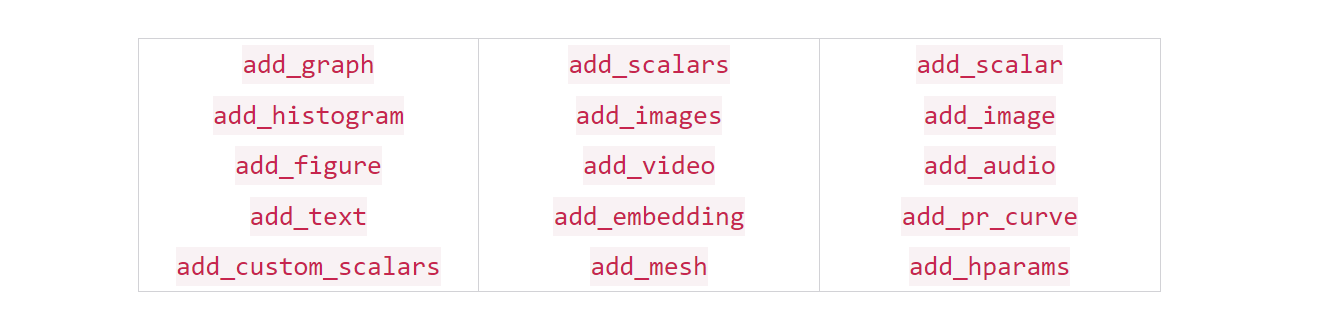

它还实现了另外两种有效地将数据写入磁盘的方法：
- flush
- close

我们将使用前两种方法， add_graph 和 add_scalars ，发送我们模型的图形，当然还有两个标量：训练和验证损失。这将与我们使用 make_dot 绘制的动态计算图略有不同。

### add_graph 方法
让我们从 add_graph 开始；不幸的是，它的文档似乎不存在（截至撰写本文时），并且它的参数默认值让您相信您不需要提供任何输入 ( input_to_model=None )。如果我们尝试它会发生什么？


In [48]:
# using add_graph with default argument values
writer.add_graph(model)

TypeError: 'NoneType' object is not iterable

我们将收到一条以 TypeError: 'NoneType' object is not iterable 结尾的巨大错误消息。

因此，我们需要将一些**输入与我们的模型一起发送**。让我们从 **train_loader** 中获取一小批数据点，然后将其作为输入传递给 add_graph ：

In [107]:
# Fetching a tuple of feature (dummy_x) and label (dummy_y)
#next() 返回迭代器的下一个项目。next() 函数要和生成迭代器的 iter() 函数一起使用。
dummy_x, dummy_y = next(iter(train_loader))

# Since our model was sent to device, we need to do the same 
# with the data.  
# Even here, both model and data need to be on the same device!
writer.add_graph(model, dummy_x.to(device))

如果您重新运行 %tensorboard --logdir runs 的单元格以查看 TensorBoard，它应该如下所示：

In [108]:
%reload_ext tensorboard
%tensorboard --logdir runs 

Reusing TensorBoard on port 6006 (pid 6856), started 1 day, 0:18:43 ago. (Use '!kill 6856' to kill it.)

将损失值发送到 TensorBoard 怎么样？我们可以使用 add_scalars 方法一次发送多个标量值，这需要以下三个参数：
- main_tag：标签的父名称或“组标签”。
- tag_scalar_dict：包含要跟踪的标量的 key: value 对的字典。在我们的例子中，训练和验证损失。
- global_step：步骤值或与您在字典中发送的值相关联的索引。在我们的例子中，我们想到了epoch，因为每个epoch都会计算损失。


它如何转化为代码？让我们来看看：

In [81]:
writer.add_scalars(
    main_tag='loss', 
    tag_scalar_dict={'training': loss, 
                     'validation': val_loss}, 
    global_step=epoch
)
writer.add_scalars('loss' ,{'training': loss, 'validation': val_loss}, epoch)
writer.close()

In [82]:
%reload_ext tensorboard
%tensorboard --logdir runs 

Reusing TensorBoard on port 6006 (pid 6856), started 19:11:43 ago. (Use '!kill 6856' to kill it.)

我们需要将这些元素合并到我们的模型配置和模型训练代码中。

In [68]:
%%writefile model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, 
# loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step = make_val_step(model, loss_fn)

# 创建 SummaryWriter 以与 TensorBoard 交互（第 24 行）。
writer = SummaryWriter('runs/simple_linear_regression') # 1)
# Fetches a single mini-batch so we can use add_graph
x_dummy, y_dummy = next(iter(train_loader))
writer.add_graph(model, x_dummy.to(device))

Writing model_configuration/v3.py


更新后的模型训练代码类似于以下内容

In [75]:
%%writefile model_training/v5.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)
    
    # VALIDATION - no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under tag "loss"
    # 将损失发送到 TensorBoard（第 20-24 行）。
    writer.add_scalars(main_tag='loss',      # 1)
                       tag_scalar_dict={
                            'training': loss, 
                            'validation': val_loss},
                       global_step=epoch)

# Closes the writer
writer.close()

Writing model_training/v5.py


在上次更新模型配置和训练部分之后，我们目前的发展状态是：
- Data preparation V2 数据准备V2
- Model configuration V3 车型配置V3
- Model training V5 模型训练V5

让我们检查模型的状态：

In [109]:

%run -i model_training/v5.py
%run -i model_configuration/v3.py
%run -i data_preparation/v2.py
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')), ('0.bias', tensor([0.8300], device='cuda:0'))])


In [79]:
%reload_ext tensorboard
%tensorboard --logdir runs 

Reusing TensorBoard on port 6006 (pid 6856), started 18:51:18 ago. (Use '!kill 6856' to kill it.)

这与我们在使用列表和 Matplotlib 之前构建的图相同。如果我们的模型足够大或足够复杂，需要至少几分钟的时间来训练，我们将能够在训练期间看到 TensorBoard 中损失的演变。如果你碰巧遇到了类似下面奇怪情节的东西，请不要担心！

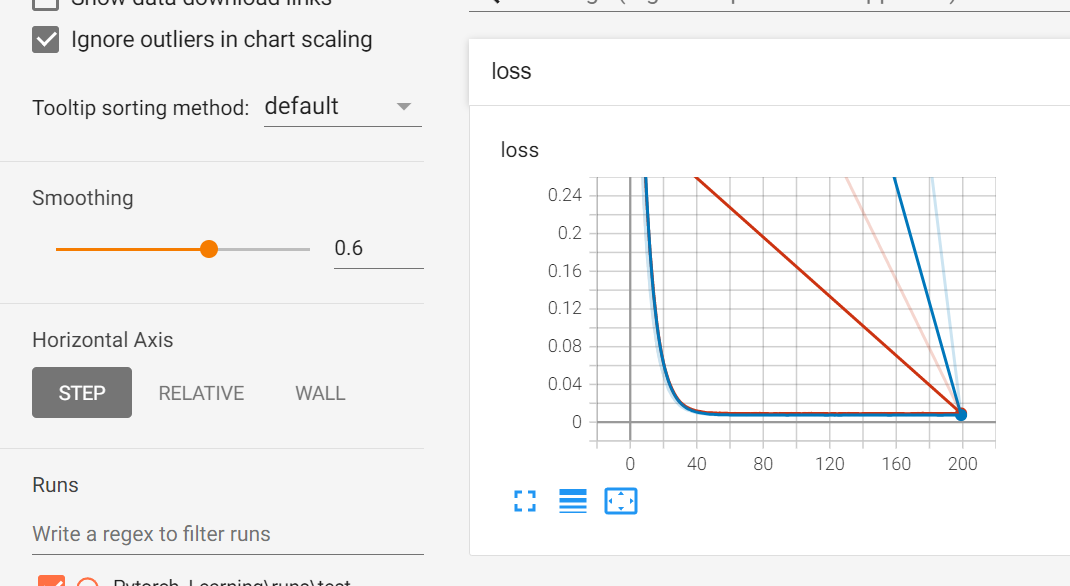

您还记得我说过将多次运行的数据写入同一个文件夹很糟糕吗？就是这个。由于我们正在将数据写入文件夹 runs/simple_linear_regression ，如果我们在第二次运行代码之前不更改文件夹的名称（或清除那里的数据），TensorBoard 会变得有些混乱，您可以从它的输出中猜到：

每次运行发现不止一个图形事件，因为我们不止一次运行了 add_graph 。

发现不止一个带有 step1 标签的 run metadata 事件，因为我们不止一次运行了 add_scalars 。

## 保存和加载模型
成功训练模型很棒。毫无疑问，但并非所有模型都能如此快速地进行训练，而且训练可能会中断（计算机崩溃、在 Google Colab 上连续使用 GPU 12 小时后超时等）。重新来过是不是很可惜啊？因此，能够检查点或保存我们的模型很重要；也就是说，将其保存到磁盘以防我们稍后想重新开始训练或将其部署为应用程序以进行预测。
### 模型状态 
要检查模型，我们基本上必须将其状态保存到一个文件中，以便稍后可以将其加载回来，实际上没什么特别的。
但是，究竟是什么定义了模型的状态？以下概述了这一点：
- model.state_dict() ：有点明显，对吧？
- optimizer.state_dict() ：记住，优化器也有一个 state_dict 。它包含关于优化器状态以及使用的超参数的信息，例如学习率，动量等。
- 损失：毕竟，您应该跟踪它的演变。
- Epoch：它只是一个数字，为​​什么不呢？

### 保存检查点 

定义模型状态后，我们现在必须将所有内容包装到 Python 字典中，并使用 **torch.save() **将其全部转储到文件中。十分简单！我们刚刚将模型保存到名为 model_checkpoint.pth 的文件中。


In [110]:
checkpoint = {'epoch': n_epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': losses,
              'val_loss': val_losses}

torch.save(checkpoint, 'model_checkpoint.pth')

如果您正在检查一个部分训练的模型以稍后恢复训练，或者如果您正在保存一个完全训练的模型以部署它并进行预测，则该过程完全相同。

### 恢复训练 

如果我们重新开始（就像我们刚刚打开电脑并启动 Jupyter），我们必须在实际加载模型之前设置。这意味着我们需要加载数据并配置模型。幸运的是，我们已经有了相应的代码：数据准备 V2 和模型配置 V3。

In [111]:
%run -i data_preparation/v2.py
%run -i model_configuration/v3.py

让我们首先仔细检查我们是否有一个未经训练的模型：

In [112]:
# checking model parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')), ('0.bias', tensor([0.8300], device='cuda:0'))])


现在我们准备好加载模型了，这很简单：
- 使用 torch.load() 加载字典。
- 使用 load_state_dict() 方法加载模型和优化器状态字典。
- 将其他所有内容加载到相应的变量中。

In [ ]:
# 使用 torch.load() 加载字典。
checkpoint = torch.load('model_checkpoint.pth')
#使用 load_state_dict() 方法加载模型和优化器状态字典
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

saved_epoch = checkpoint['epoch']
saved_losses = checkpoint['loss']
saved_val_losses = checkpoint['val_loss']

print(model.train()) # always use TRAIN for resuming training         # 1)

现在让我们检查模型：

In [114]:
# checking model parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')), ('0.bias', tensor([0.8300], device='cuda:0'))])


接下来，我们可以运行模型训练 V5，再训练 200 个 epoch。

In [137]:
# running model training v5 script
%run -i model_training/v5.py

In [138]:
# checking model parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9429]], device='cuda:0')), ('0.bias', tensor([1.0249], device='cuda:0'))])


## 完整代码
数据准备V2 
```python
torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
train_data, val_data = random_split(dataset, [n_train, n_val]) 
# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_data, 
    batch_size=16, 
    shuffle=True,
)
val_loader = DataLoader(dataset=val_data, batch_size=16)
```
模型配置 V3 
```python
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, 
# loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step = make_val_step(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')
# Fetches a single mini-batch so we can use add_graph
x_dummy, y_dummt = next(iter(train_loader))
writer.add_graph(model, x_dummy.to(device))
```
模型训练V5 
```python
# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)
    
    # VALIDATION - no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under tag "loss"
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={
                            'training': loss, 
                            'validation': val_loss},
                       global_step=epoch)

# Closes the writer
writer.close()
```
检查模型
```python
# Checking model parameters
print(model.state_dict())
```

In [141]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
train_data, val_data = random_split(dataset, [n_train, n_val]) 
# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_data, 
    batch_size=16, 
    shuffle=True,
)
val_loader = DataLoader(dataset=val_data, batch_size=16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, 
# loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step = make_val_step(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')
# Fetches a single mini-batch so we can use add_graph
x_dummy, y_dummt = next(iter(train_loader))
writer.add_graph(model, x_dummy.to(device))
# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)
    
    # VALIDATION - no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under tag "loss"
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={
                            'training': loss, 
                            'validation': val_loss},
                       global_step=epoch)

# Closes the writer
writer.close()
# Checking model parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])
